* 최초작성일자: 231103
* 실행환경: 구글 코랩

### 구글 드라이브 마운트

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 경로 설정
%cd /content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲


'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

### 라이브러리 설치, 불러오기

In [12]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.8 MB/s eta 0:00:00


In [13]:
from transformers import ViTModel

import os
from PIL import Image

from torchvision.transforms import ToTensor

import numpy as np
from tqdm import tqdm

import torch

### 수집한 이미지를 벡터로 만들기
사전훈련된 신경망 vit을 가져와서 인코더 부분을 사용하여 벡터로 만든다
* https://huggingface.co/google/vit-base-patch16-224

In [79]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [189]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [83]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [84]:
model = model.to(device)

In [85]:
# !nvidia-smi

In [224]:
# 텐서로 변환하는 함수
tf_toTensor = ToTensor()

input_dir = "주민이미지/"

file_name_lst = []
latent_vector_lst = []
folder_names = os.listdir(input_dir)

model.eval()

for folder_name in tqdm(folder_names):
    # print(folder_name)

    file_names = os.listdir(input_dir+folder_name)
    for file_name in file_names:
        # print(file_name)
        file_name_lst.append(folder_name+"/"+file_name)
        input = Image.open(input_dir+folder_name+"/"+file_name)
        input = tf_toTensor(input)

        with torch.no_grad():

            latent_vector = model(input.unsqueeze(0).to(device), interpolate_pos_encoding=True)
            latent_vector = latent_vector['pooler_output'][0]

            latent_vector_lst.append(latent_vector)



100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


In [235]:
latent_vector_lst_numpy = np.array([t.cpu().numpy() for t in latent_vector_lst])

In [237]:
latent_vector_lst_numpy.shape

(380, 768)

In [238]:
np.save('animal_data.npy', latent_vector_lst_numpy)

In [239]:
file_name_lst[:5]

['horse/horse_8.jpg',
 'horse/horse_11.jpg',
 'horse/horse_4.jpg',
 'horse/horse_9.jpg',
 'horse/horse_6.jpg']

In [240]:
# 텍스트 파일로 저장하기
file = open("file_name_lst.txt", "w")
file.write(str(file_name_lst))
file.close()

### 유사도 계산하기
Faiss 알고리즘 사용

In [2]:
import numpy as np

In [3]:
# 저장한 임베딩 벡터 불러오기
animal_data = np.load('animal_data.npy', allow_pickle=True)
animal_data.shape

(380, 768)

In [38]:
# 텍스트 파일 읽기
def read_txt_file(filename):
  f = open(filename, 'r')     # mode = 부분은 생략해도 됨
  str = f.read()

  return eval(str)

In [86]:
file_name_lst = read_txt_file('file_name_lst.txt')

In [4]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 72.8 MB/s eta 0:00:00


In [5]:
import faiss

In [8]:
# 인덱스 추가하기
Index = faiss.IndexFlatL2(animal_data.shape[1])
print(Index.is_trained)		# True
Index.add(animal_data)
print(Index.ntotal)

True
380


In [9]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

In [15]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


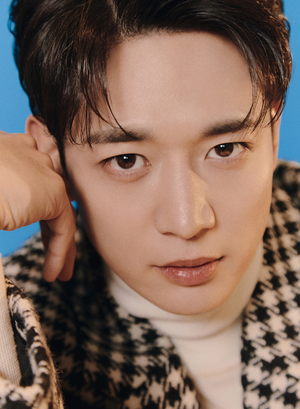

In [178]:
tf_toTensor = ToTensor()

input_dir = "query_images/"
file_name = '민호.jpg'



model.eval()


input = Image.open(input_dir + file_name)

# 이미지 출력
img = input
base_width= 300
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
display(img)


input = tf_toTensor(input)

with torch.no_grad():
    if input.shape[0] == 4:
        input = input[:3]
    latent_vector = model(input.unsqueeze(0).to(device), interpolate_pos_encoding=True)
    latent_vector = latent_vector['pooler_output'][0]

In [158]:
k = 3
distances, indexes = Index.search(latent_vector.unsqueeze(0), k)

print(distances)
print(indexes[0])

deer/deer_10.jpg


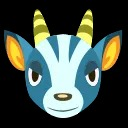

mouse/mouse_9.jpg


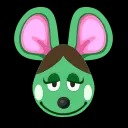

hamster/hamster_7.jpg


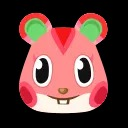

In [175]:
for idx in indexes[0]:
    file_name = file_name_lst[idx]
    print(file_name)

    embedding_img_dir = "주민이미지/"
    input = Image.open(embedding_img_dir + file_name)
    display(input)

작동 테스트

In [18]:
# 작동 테스트
# 테스트를 위해 index add했던거로 확인함
# Index는 faiss Index 객체를 의미
# indexes는 우리가 흔히 말하는 정수 인덱스를 의미
k = 3
distances, indexes = Index.search(animal_data[:3], k)

In [20]:
# animal_data가 전부 Index에 들어가 있어서 각 Top1 인덱스는 자기 자신의 인덱스다.
# 자기 자신과의 거리는 0이므로, 각 Top1 거리 값도 0
distances

array([[  0.     ,  70.91631,  81.45494],
       [  0.     ,  77.96408,  88.66243],
       [  0.     , 124.31059, 129.85442]], dtype=float32)

In [21]:
# 거리가 가까운 순서대로 index를 출력해줌
# 출력된 인덱스를 다시 사진으로 확인해야 하는 작업이 필요함.
indexes

array([[  0,   4,  11],
       [  1,   3,  10],
       [  2,   1, 189]])